### 1.Set up and load Data

1.1 Install Dependencies and Setup

In [205]:
# %pip install tensorflow tenserflow-gpu opencv-python matplotlib

In [206]:
# %pip list

In [207]:
import tensorflow as tf
import os

In [208]:
print("TF version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("GPU Device:", tf.test.gpu_device_name())


TF version: 2.10.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Device: /device:GPU:0


In [209]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [210]:
# Avoid OOM error by setting GPU memory consumption growth
tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

1.2 Remove dodgy images

In [211]:
import cv2
import imghdr

In [212]:
data_dir = 'data'

In [213]:
os.listdir(data_dir)

['happy people', 'sad people']

In [214]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [215]:
for image_class in os.listdir(data_dir): # list image class
    for image in os.listdir(os.path.join(data_dir, image_class)): # list image in each class
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image is not  in ext list  {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_exts))
            

1.3 Load Data

In [216]:
import numpy as np
from matplotlib import pyplot as plt

In [217]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [218]:
tf.keras.utils.image_dataset_from_directory??

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)
Source:   
@keras_export(
    "keras.utils.image_dataset_from_directory",
    "keras.preprocessing.image_dataset_from_directory",
    v1=[],
)
def image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
):
    """Generates a `tf.data.Dataset` from image files in a directory.

    If your directory structure is:



In [219]:
data_iterator = data.as_numpy_iterator()

In [220]:
# Get another batch from the iterator
batch = data_iterator.next()

In [221]:
# Imaages representd as  numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [222]:
# Class 1 = sad 
# Class 0 = happy
batch[1]

array([1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0])

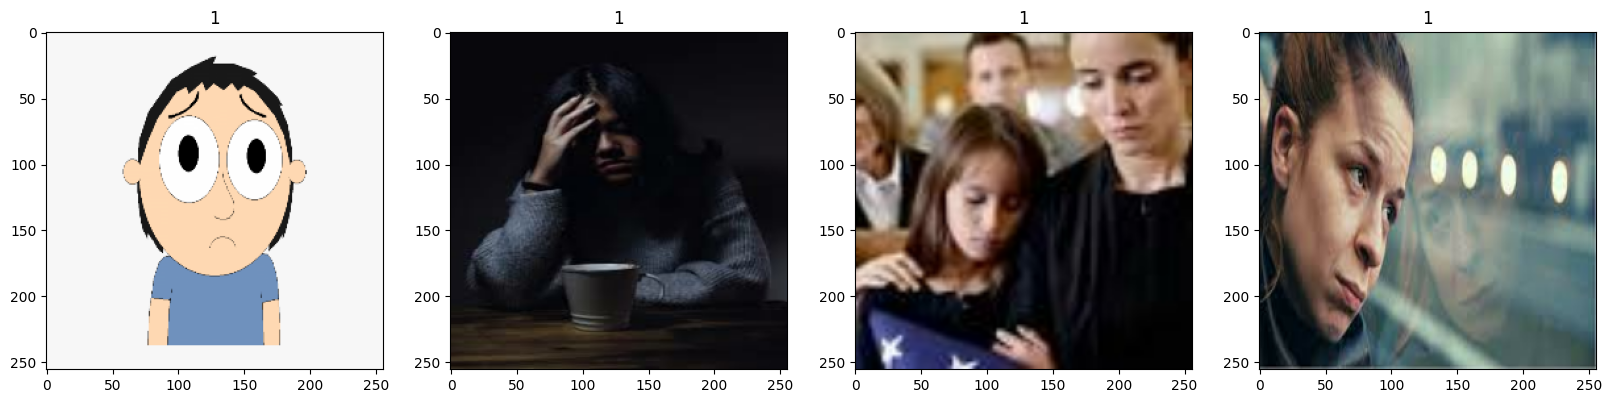

In [223]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

1.4 Scale Data

In [224]:
scaled = batch[0] /255

In [225]:
scaled.max()

1.0

### 2.Preprocess data

2.1 Scale Data

In [226]:
data = data.map(lambda x,y: (x/255,y))

In [227]:
scaled_iterator = data.as_numpy_iterator()

In [228]:
batch = scaled_iterator.next()

In [229]:
batch[0].min()

0.0

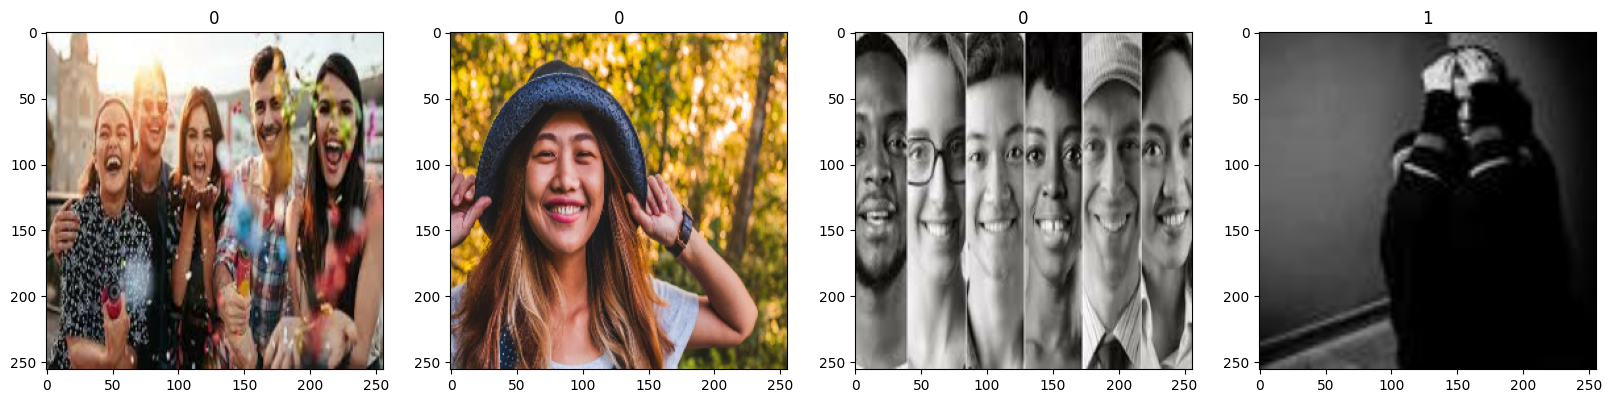

In [230]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

2.2 split data

In [231]:
len(data)

10

In [232]:
train_size = int(len(data)*.6)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [233]:
train_size+val_size+test_size

11

In [234]:
train = data.take(train_size) # ใช้ data กี่ตัวในการtrain
val = data.skip(train_size).take(val_size) # skip data ที่เอาไป train แล้ว
test = data.skip(train_size+val_size).take(test_size)

In [235]:
len(train)

6

### 3.Deep Model

3.1 Build Deep Learning Model

In [236]:
from tensorflow.keras.models import  Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [237]:
model = Sequential()

activation='relu'
✅ ข้อดี:
- ทำงานเร็ว คำนวณง่าย

- ลดปัญหา vanishing gradient ที่เจอบ่อยกับ Sigmoid

- ช่วยให้ deep network ฝึกได้ดีขึ้น

- เหมาะกับ convolutional layers อย่างมาก (เช่นในตัวอย่างของคุณ)

⚠️ ข้อเสีย:
- มีโอกาสเกิด “dying ReLU” (ค่าทั้งหมดกลายเป็น 0 ถ้า weight ทำให้ input ติดลบตลอด)

activation='sigmoid'
✅ ข้อดี:
- เหมาะกับปัญหา binary classification (เช่น output layer)

- ให้ความน่าจะเป็นเข้าใจง่าย (0 = ไม่แน่ใจ, 1 = มั่นใจ)

⚠️ ข้อเสีย:
- มีปัญหา vanishing gradient (gradient เล็กมากเมื่อค่าเข้าใกล้ 0 หรือ 1)

- ค่าที่ออกมาจะไม่เป็น 0-mean → ทำให้การเรียนรู้ช้าลง

- ไม่ค่อยนิยมใช้ใน hidden layers ของ deep network แล้ว

In [238]:
# add convolutiuon 16 filter, 3*3 pixels, stride 1 pixel each time
# relu activation เป็นกราฟรูปแบบหนึ่งจะไม่ติดลบ ต่างกับ Sigmoid

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [239]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [240]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 16)      

3.2 Train

In [241]:
logdir = 'logs'

In [242]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [243]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
6/6 [==============================] - 13s 426ms/step - loss: 1.0151 - accuracy: 0.5260 - val_loss: 0.6657 - val_accuracy: 0.5312
Epoch 2/20
6/6 [==============================] - 4s 385ms/step - loss: 0.6731 - accuracy: 0.5052 - val_loss: 0.6595 - val_accuracy: 0.5312
Epoch 3/20
6/6 [==============================] - 3s 376ms/step - loss: 0.6446 - accuracy: 0.6458 - val_loss: 0.6153 - val_accuracy: 0.7917
Epoch 4/20
6/6 [==============================] - 3s 386ms/step - loss: 0.5669 - accuracy: 0.8125 - val_loss: 0.5346 - val_accuracy: 0.6771
Epoch 5/20
6/6 [==============================] - 3s 401ms/step - loss: 0.4612 - accuracy: 0.8021 - val_loss: 0.3578 - val_accuracy: 0.8229
Epoch 6/20
6/6 [==============================] - 4s 427ms/step - loss: 0.3959 - accuracy: 0.8438 - val_loss: 0.5117 - val_accuracy: 0.7500
Epoch 7/20
6/6 [==============================] - 4s 428ms/step - loss: 0.4123 - accuracy: 0.7552 - val_loss: 0.3801 - val_accuracy: 0.8646
Epoch 8/20
6/6 [===

3.3 Plot performance

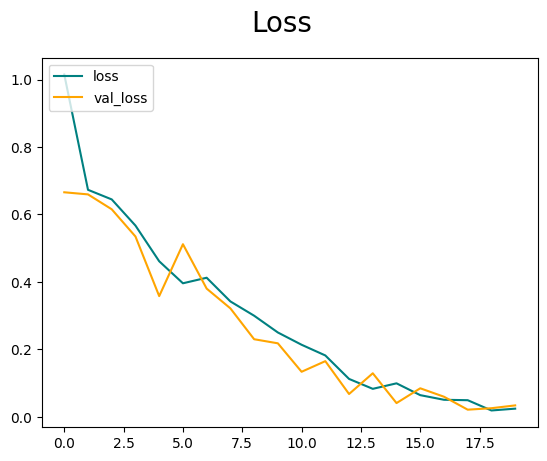

In [244]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

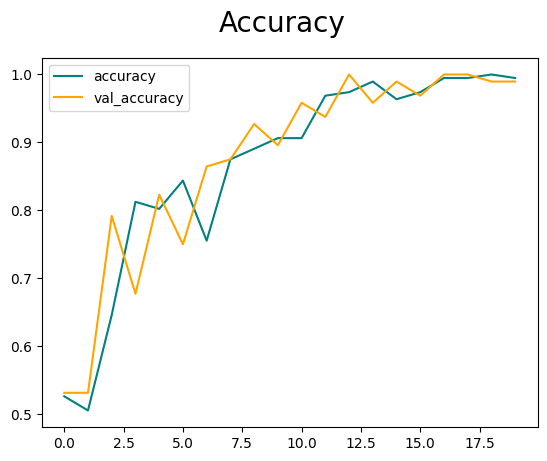

In [245]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### 4. Evaluate Performance

4.1 Evaluate

In [246]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [247]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [248]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 452ms/step


In [249]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


4.2 Test

In [250]:
import cv2

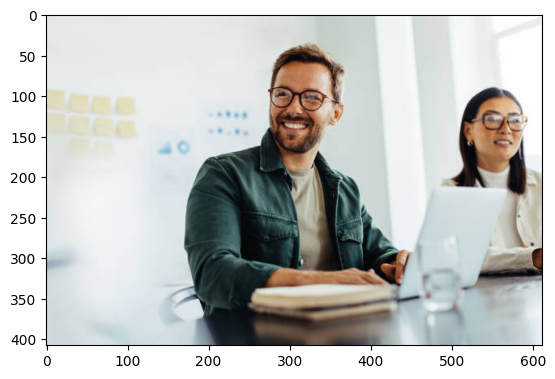

In [305]:
img = cv2.imread('happy_test2.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

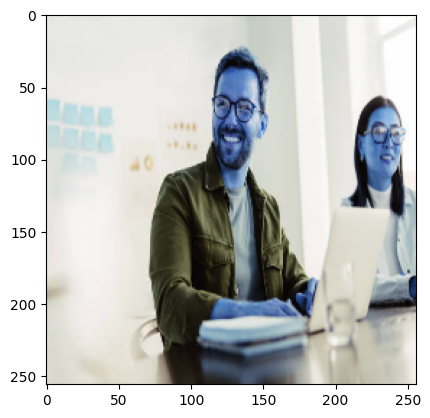

In [306]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [307]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 31ms/step


In [308]:
yhat

array([[0.9781091]], dtype=float32)

In [309]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


### 5. Save Model

In [284]:
from tensorflow.keras.models import load_model

In [285]:
model.save(os.path.join('models', 'happy_sad_model.h5'))

In [286]:
new_model = load_model(os.path.join('models', 'happy_sad_model.h5'))

In [296]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 28ms/step


In [299]:
yhatnew

array([[0.99648917]], dtype=float32)

In [297]:
if yhatnew > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad
